In [26]:
import sys
from copy import deepcopy 

from izhi2019_wrapper import IzhiCell
from izhi_network import IzhiModularizedNetwork
import matplotlib.pyplot as plt
from utils import *
import numpy as np

%load_ext autoreload
%autoreload 2

%matplotlib qt


random = np.random.RandomState(seed=1000)
print('...done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
...done


In [27]:
nlayer1, nlayer2 = 10, 10
npermodule_l1, npermodule_l2 = 1, 30

net = IzhiModularizedNetwork(nlayer1, npermodule_l1, nlayer2, npermodule_l2, feedback_layer1=False, feedback_layer2=True)
print('generated network toplogy')

generated network toplogy


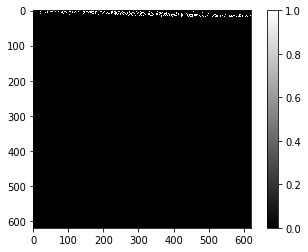

In [28]:
cm = net.get_connectivity_matrix()
plt.figure()
plt.imshow(cm, cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [30]:
frequencies = random.normal(3., 3., size=(nlayer1,))
scaling = 0.1
coupling    = random.uniform(scaling*0.01, scaling*0.05, size=(nlayer1,nlayer1))
for i in xrange(coupling.shape[0]):
    coupling[i,i] = 0.0
steps = 12000.
run_time  = 120.
print(frequencies)
# print(coupling)

[-0.60810998 11.58530753 -5.04477734 -0.50643528  1.24750733  5.45474909
  7.77131169  2.2251353   4.34108712  8.81525923]


In [31]:
import time

tmax = 5. # seconds
tic = time.time()
net.instantiate_kuramoto_network(frequencies, coupling, steps, run_time)
elapsed = time.time() - tic
print('kuromoto simulation completed in %0.3f seconds' % elapsed)

tic = time.time()
net.simulate(tmax)
elapsed = time.time() - tic
print('Neurons simulated.. That took %0.3f seconds' % elapsed)

tic = time.time()
net.extract_spike_times(layer=1)
net.extract_spike_times(layer=2)
elapsed = time.time() - tic
print('Acquired spike trains for both layers in %0.3f seconds' % elapsed)

kuromoto simulation completed in 11.627 seconds
Neurons simulated.. That took 159.318 seconds
Acquired spike trains for both layers in 1.311 seconds


In [35]:
all_cells = net.cell_attributes.copy()

l1_cells = get_layer(all_cells, layer=1)
l2_cells = get_layer(all_cells, layer=2)

module_cells = []
for i in xrange(nlayer2):
    module_cells.append(get_module(all_cells, layer=2, module=i, cell_type='both'))

    
l1_synch = get_synch_from_voltages(l1_cells)
print('layer 1 synch calculated')
l2_synch = get_synch_from_voltages(l2_cells)
print('layer 2 synch calculated')
# e_synch = get_synch_from_voltages(e_cells)
# print('excitatory cell synch calculated')
# i_synch = get_synch_from_voltages(i_cells)
# print('inhibitory cell synch calculated')

module_synchs = []
for (i,module) in enumerate(module_cells):
    module_synchs.append(get_synch_from_voltages(module))
    print(i)

layer 1 synch calculated
layer 2 synch calculated
0
1
2
3
4
5
6
7
8
9


('l1-l2 synch: ', 0.1529451835366978)


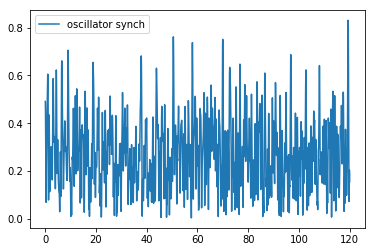

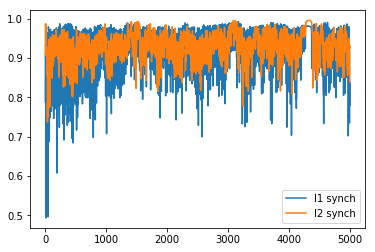

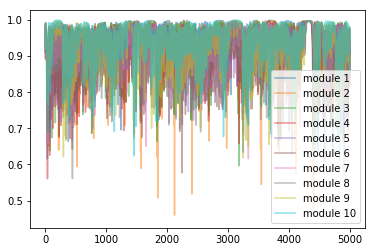

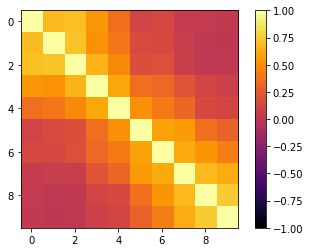

In [36]:
%matplotlib inline


synchrony = net.kuramoto_network['dynamic synchrony']
ktime     = net.kuramoto_network['dynamic time']
plt.figure()
plt.plot(ktime, synchrony, label='oscillator synch')
plt.legend()

plt.figure()
plt.plot(net.kuramoto_sim_time, l1_synch, label='l1 synch')
plt.plot(net.kuramoto_sim_time, l2_synch, label='l2 synch')
plt.legend()

# plt.figure()
# plt.plot(net.kuramoto_sim_time, e_synch, label='e synch')
# plt.plot(net.kuramoto_sim_time, i_synch, label='i synch')
# plt.legend()

plt.figure()
for i in xrange(len(module_synchs)):
    plt.plot(net.kuramoto_sim_time, module_synchs[i], label='module %i' % (i+1), alpha=0.5)
plt.legend()


print('l1-l2 synch: ', np.corrcoef(l1_synch, l2_synch)[0][1])
micro_corr = np.corrcoef(module_synchs)

plt.figure()
plt.imshow(micro_corr, vmin=-1., vmax=1., cmap='inferno')
plt.colorbar()

plt.show()

In [37]:
# Get spike times

cells = net.cell_attributes
simulation_time = net.kuramoto_sim_time
spike_times_l1 = net.spiketrains[1]
spike_times_l2 = net.spiketrains[2]

excitatory_spikes_l1 = get_spikes_from_cell_type(cells, spike_times_l1, cell_type='e')
inhibitory_spikes_l1 = get_spikes_from_cell_type(cells, spike_times_l1, cell_type='i')

excitatory_spikes_l2 = get_spikes_from_cell_type(cells, spike_times_l2, cell_type='e')
inhibitory_spikes_l2 = get_spikes_from_cell_type(cells, spike_times_l2, cell_type='i')
print('done...')

# Get spike times as lists where each entry is a neuron

spike_times_l1_lst = spike_times_l1.values()
spike_times_l2_lst = spike_times_l2.values()

excitatory_spike_times_l1_lst = excitatory_spikes_l1.values()
excitatory_spike_times_l2_lst = excitatory_spikes_l2.values()
inhibitory_spike_times_l1_lst = inhibitory_spikes_l1.values()
inhibitory_spike_times_l2_lst = inhibitory_spikes_l2.values()

excitatory_spike_times_lst = deepcopy(excitatory_spike_times_l1_lst) + deepcopy(excitatory_spike_times_l2_lst)
inhibitory_spike_times_lst = deepcopy(inhibitory_spike_times_l1_lst) + deepcopy(inhibitory_spike_times_l2_lst)

print('done...')


done...
done...


In [23]:

chunk = 25
binned_spikes_l1, binned_times_l1 = bin_activity(simulation_time, spike_times_l1_lst, len(spike_times_l1_lst), dt=0.025, chunk=chunk)
print('layer 1 spikes binned...')
binned_spikes_l2, binned_times_l2 = bin_activity(simulation_time, spike_times_l2_lst, len(spike_times_l2_lst), dt=0.025, chunk=chunk)
print('layer 2 spikes binned...')
binned_spikes_e, binned_times_e = bin_activity(simulation_time, excitatory_spike_times_lst, len(excitatory_spike_times_lst), dt=0.025, chunk=chunk)
print('excitatory spikes binned')
binned_spikes_i, binned_time_i = bin_activity(simulation_time, inhibitory_spike_times_lst, len(inhibitory_spike_times_lst), dt=0.025, chunk=chunk)
print('inhibitory spikes binned')



layer 1 spikes binned...
layer 2 spikes binned...
excitatory spikes binned
inhibitory spikes binned


In [24]:
# Get PSTH for each group

network_activation_l1 = get_PSTH(binned_spikes_l1, len(binned_spikes_l1), chunk/1000., filt=True)
network_activation_l2 = get_PSTH(binned_spikes_l2, len(binned_spikes_l2), chunk/1000., filt=True)
network_activation_e  = get_PSTH(binned_spikes_e, len(binned_spikes_e), chunk/1000., filt=True)
network_activation_i  = get_PSTH(binned_spikes_i, len(binned_spikes_i), chunk/1000., filt=True)
print('done')

done


In [13]:
# get ISIs

l1_ISI_lst, l2_ISI_lst = [], []
e_ISI_lst, i_ISI_lst   = [], []
for spike_times_l1 in spike_times_l1_lst:
    l1_ISI_lst.append(get_ISI(spike_times_l1))
for spike_times_l2 in spike_times_l2_lst:
    l2_ISI_lst.append(get_ISI(spike_times_l2))
for spike_times_e in excitatory_spike_times_lst:
    e_ISI_lst.append(get_ISI(spike_times_e))
for spike_times_i in inhibitory_spike_times_lst:
    i_ISI_lst.append(get_ISI(spike_times_i))
print('done')

done


In [15]:
# get CVs

l1_cv_lst, l2_cv_lst = [], []
e_cv_lst, i_cv_lst   = [], []
for spike_times_l1 in spike_times_l1_lst:
    l1_cv_lst.append(get_CV(spike_times_l1))
for spike_times_l2 in spike_times_l2_lst:
    l2_cv_lst.append(get_CV(spike_times_l2))
for spike_times_e in excitatory_spike_times_lst:
    e_cv_lst.append(get_CV(spike_times_e))
for spike_times_i in inhibitory_spike_times_lst:
    i_cv_lst.append(get_CV(spike_times_i))
    
l1_cv_lst = [x for x in l1_cv_lst if str(x) != 'nan']
l2_cv_lst = [x for x in l2_cv_lst if str(x) != 'nan']
e_cv_lst  = [x for x in e_cv_lst if str(x) != 'nan']
i_cv_lst  = [x for x in i_cv_lst if str(x) != 'nan']
print('done')

done


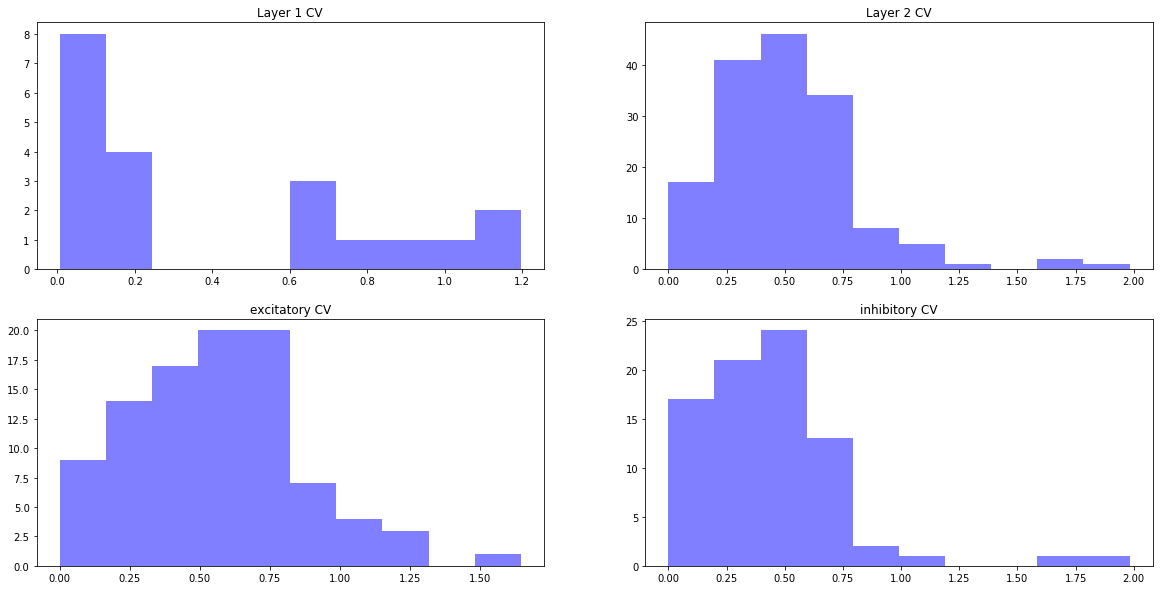

In [20]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,10))

ax1.hist(l1_cv_lst, alpha=0.5, color='b')
ax1.set_title('Layer 1 CV')

ax2.hist(l2_cv_lst, alpha=0.5, color='b')
ax2.set_title('Layer 2 CV')

ax3.hist(e_cv_lst, alpha=0.5, color='b')
ax3.set_title('excitatory CV')

ax4.hist(i_cv_lst, alpha=0.5, color='b')
ax4.set_title('inhibitory CV')

plt.show()

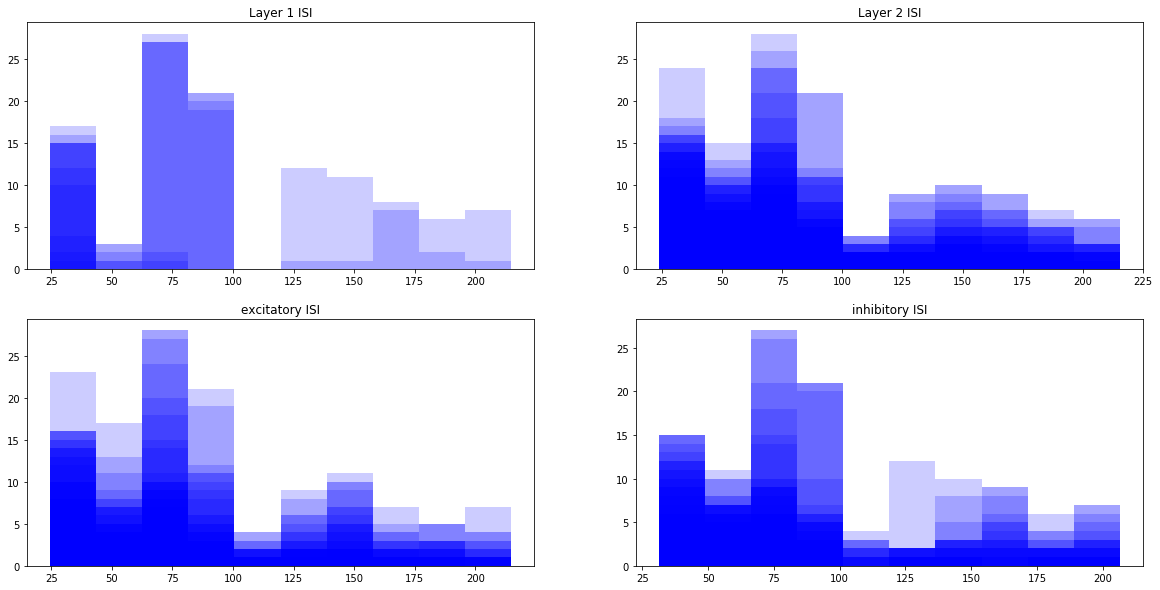

In [21]:
def plot_ISI(ISI_lst, ax, title):
    for (i,ISI) in enumerate(ISI_lst):
        if i == 0:
            _, bins, _ = ax.hist(ISI, alpha=0.2, color='b')
        else:
            ax.hist(ISI, bins=bins, alpha=0.2, color='b')
    ax.set_title(title)
        
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,10))
plot_ISI(l1_ISI_lst, ax1, 'Layer 1 ISI')
plot_ISI(l2_ISI_lst, ax2, 'Layer 2 ISI')
plot_ISI(e_ISI_lst, ax3, 'excitatory ISI')
plot_ISI(i_ISI_lst, ax4, 'inhibitory ISI')

plt.show()


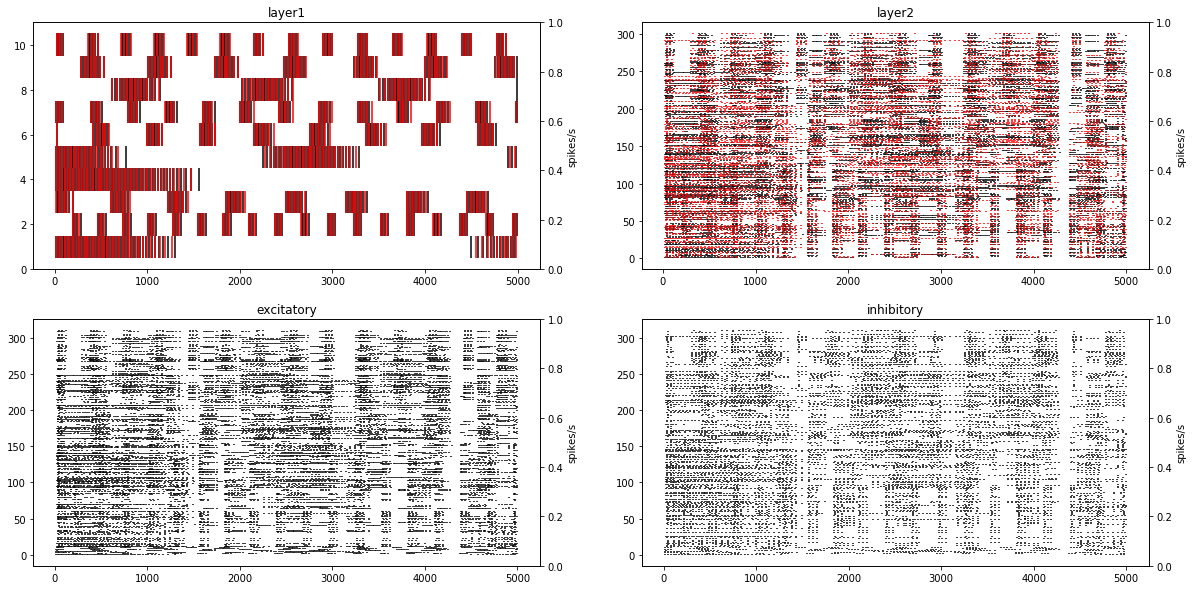

In [38]:
%matplotlib inline

fig, ( (ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,10))
for (i,gid) in enumerate(sorted(excitatory_spikes_l1)):
    ax1.vlines(excitatory_spikes_l1[gid], i + 0.5, i + 1.5, 'black')
for (i,gid) in enumerate(sorted(inhibitory_spikes_l1)):
    ax1.vlines(inhibitory_spikes_l1[gid], i + 0.5, i + 1.5, 'r')
ax1.set_title('layer1')
ax11 = ax1.twinx()
#ax11.plot(binned_times_l1, network_activation_l1, 'b', alpha=0.5)
ax11.set_ylabel('spikes/s')

for (i, gid) in enumerate(sorted(excitatory_spikes_l2)):
    ax2.vlines(excitatory_spikes_l2[gid], i + 0.5, i + 1.5, 'black')
for (i, gid) in enumerate(sorted(inhibitory_spikes_l2)):
    ax2.vlines(inhibitory_spikes_l2[gid], i + 0.5, i + 1.5, 'r')
ax22 = ax2.twinx()
#ax22.plot(binned_times_l2, network_activation_l2, 'b', alpha=0.5)
ax22.set_ylabel('spikes/s')
ax2.set_title('layer2')


excitatory_spikes_full = excitatory_spikes_l1.copy()
excitatory_spikes_full.update(excitatory_spikes_l2)

inhibitory_spikes_full = inhibitory_spikes_l1.copy()
inhibitory_spikes_full.update(inhibitory_spikes_l2)

for (i,gid) in enumerate(sorted(excitatory_spikes_full)):
    ax3.vlines(excitatory_spikes_full[gid], i + 0.5, i + 1.5, 'black')
ax3.set_title('excitatory')
ax33 = ax3.twinx()
#ax33.plot(binned_times_e, network_activation_e, 'b', alpha=0.5)
ax33.set_ylabel('spikes/s')

for (i, gid) in enumerate(sorted(inhibitory_spikes_full)):
    ax4.vlines(inhibitory_spikes_full[gid], i + 0.5, i + 1.5, 'black')
ax4.set_title('inhibitory')
ax44 = ax4.twinx()
#ax44.plot(binned_time_i, network_activation_i, 'b', alpha=0.5)
ax44.set_ylabel('spikes/s')

plt.show()